In [1]:
# Should be first to load all the env vars for browser
import os
from dotenv import load_dotenv

load_dotenv()

assert os.getenv("CHROME_USER_DATA_DIR", None)

# Needed to use the static/ default folder with the cache
from browser import BRAVE_SEARCH_SESSION

BRAVE_SEARCH_SESSION.browser.chrome_user_data_dir

sh: pidof: command not found


'/Users/maksim.rostov/pdev/freelectron/free-generalist/static/browser_cache'

In [2]:
from typing import TypedDict

from generalist.agents.core import AgentPlan
from generalist.tools.data_model import ContentResource, ShortAnswer, Task

class ExecutionState(TypedDict):
    # what user is asking to do for them 
    ask: str
    # Identifies what the original question/task given, which objective it got transferred to, what the plan to get an answer is
    task: Task
    # order index of the step of the task's plan that is being executed 
    step: int
    # Clues, findings and answers to the previous subtasks
    # Used to execute a capability plan step given already found information
    context: str  
    # capability plan for this task (overwritten when a new subtask from the main plain is picked up)
    capability_plan: AgentPlan
    # capability plan step order 
    capability_plan_step: int
    # answers to subtask, the last one should be the final answer to the task 
    answers: list[ShortAnswer]
    # all text resources that might be needed to execute the task
    resources: list[ContentResource]
    # tools that already got called
    # TODO: see if this is needed 
    tools_called: str

MAX_STEPS = 2

/Users/maksim.rostov/pdev/freelectron/free-generalist/.venv/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'validate_default' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'validate_default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(


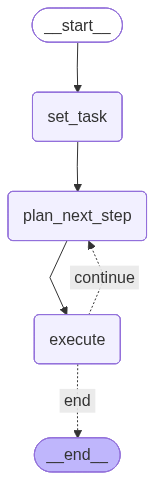

In [3]:
import json
from generalist.agents.core import AgentDeepWebSearch, AgentUnstructuredDataProcessor, \
    AgentCodeWriterExecutor, AgentAudioProcessor, AgentOutput
from generalist.tools.planning import determine_capabilities, create_plan
from generalist.tools.summarisers import construct_short_answer
from langgraph.graph import StateGraph, START, END


def init_state(ask: str, resources: list[ContentResource] | None = None) -> ExecutionState:
    return ExecutionState(
        ask=ask,
        task=None,
        step=None,
        context="",
        answers=list(),
        resources=resources if resources else [],
    )

def set_task(state: ExecutionState) -> ExecutionState:
    question_task = state["ask"]
    task_plan_response = create_plan(question_task)

    result = json.loads(task_plan_response)
    task = Task(
      question=question_task,
      objective=result["objective"],
      plan=result["plan"],
    )
    identified_resource = result.get("resource", None)
    if identified_resource:
        task_resource = ContentResource(
            provided_by="user",
            content=identified_resource.get("content", None),
            link=identified_resource.get("link", None),
            metadata={},
        )
        state["resources"].append(task_resource)
    state["task"] = task

    state["step"] = 0
    return state

def evaluate_task_completion(state: ExecutionState) -> str:
    short_answer = construct_short_answer(
        state["task"].objective,
        state["context"]
    )

    # Early stopping if answer exists
    if short_answer.answered:
        return "end"

    # Early stopping if maximum number of steps reached
    if state['step'] >= MAX_STEPS:
        return "end"

    return "continue"

def plan_next_step(state: ExecutionState) -> ExecutionState:
    # Automatically determine which step to execute based on context
    capability_plan_json = determine_capabilities(
        task=state["task"],
        context=state["context"]
    )

    state["capability_plan"] = AgentPlan.from_json(capability_plan_json)
    return state

def execute(state: ExecutionState) -> ExecutionState:
    activity, capability = state["capability_plan"].subplan[0]
    output = AgentOutput(activity)
    capability_agent = capability(activity)
    if capability is AgentDeepWebSearch:
        output = capability_agent.run()
    elif capability is AgentUnstructuredDataProcessor:
        output = capability_agent.run(state["resources"])
    elif capability is AgentCodeWriterExecutor:
        output = capability_agent.run(state["resources"])
    elif capability is AgentAudioProcessor:
        output = capability_agent.run(state["resources"])
    else:
        print("DEBUG | run_capability | Call to unidentified agent: ", capability)

    if output.answers:
        state["answers"].extend(output.answers)
    if output.resources:
        state["resources"].extend(output.resources)

    # Update context with step results
    state["context"] += f"\nStep {capability_agent.name}: {state['answers']}"
    state["step"] += 1

    return state


workflow = StateGraph(state_schema=ExecutionState)

workflow.add_node("set_task", set_task)
workflow.add_node("plan_next_step", plan_next_step)
workflow.add_node("execute", execute)

workflow.add_edge(START, "set_task")
workflow.add_edge("set_task", "plan_next_step")
workflow.add_edge("plan_next_step", "execute")
workflow.add_conditional_edges(
    "execute",
    evaluate_task_completion,
    {
        "continue": "plan_next_step",
        "end": END,
    }
)

generalist_graph = workflow.compile()

from IPython.display import Image, display
display(Image(generalist_graph.get_graph().draw_mermaid_png()))

In [4]:
import os
import logging
from dotenv import load_dotenv

import mlflow
from huggingface_hub import snapshot_download
from datasets import load_dataset


logging.getLogger().setLevel(logging.INFO)
load_dotenv()


gaia_path = os.environ.get("HUGGING_FACE_GAIA_FOLDER_PATH")
data_dir = snapshot_download(local_dir=gaia_path,  local_files_only=True, repo_id="gaia-benchmark/GAIA", repo_type="dataset")

dataset = load_dataset(data_dir, "2023_level1", split="validation")
gaia_keys = ['task_id', 'Question', 'Level', 'Final answer', 'file_name', 'file_path', 'Annotator Metadata']

sosa_many_studio_albums_task_id = "8e867cd7-cff9-4e6c-867a-ff5ddc2550be"
running_to_the_moon_task_id = "e1fc63a2-da7a-432f-be78-7c4a95598703"
dr_who_season_9_eps_11_location_task_id = "4b6bb5f7-f634-410e-815d-e673ab7f8632"
calc_sales_xlsx_task_id = "7bd855d8-463d-4ed5-93ca-5fe35145f733"
just_running_python_task_id = "f918266a-b3e0-4914-865d-4faa564f1aef"
evaluation_tasks = [
    just_running_python_task_id,
    sosa_many_studio_albums_task_id,
    calc_sales_xlsx_task_id,
    running_to_the_moon_task_id,
]

results = []
dataset_questions = { sample["task_id"]:sample for sample in dataset }
for sample_task_id in evaluation_tasks:
    sample = dataset_questions[sample_task_id]
    [ print(k, "=", sample[k]) for k in gaia_keys ]

    mlflow.langchain.autolog()                                               # this is needed to register traces within the experiment
    experiment_name = f"gaia_{"_".join(sample["task_id"].split("-"))}"
    mlflow.set_experiment(experiment_name)
    mlflow.models.set_model(generalist_graph)
    logging.getLogger().setLevel(logging.INFO)

    experiment_url = mlflow.get_experiment_by_name(experiment_name)
    # mlflow.set_tracking_uri('http://localhost:5000')

    question = sample["Question"]
    resources = []
    if sample["file_path"]:
        resource = ContentResource(
            provided_by="user",
            content="file provided with the main task",
            link=os.path.join(os.environ.get("HUGGING_FACE_GAIA_FOLDER_PATH"), sample["file_path"]),
            metadata={"note":"the file is already in the list of available resources"}
        )
        print(resource.link)
        resources.append(resource)
    initial_state = init_state(question, resources=resources)
    final_state = generalist_graph.invoke(initial_state)
    answers = final_state["answers"]
    results.append((sample, {"answers":answers, "experiment_url": experiment_url}))

Returning existing local_dir `/Users/maksim.rostov/pdev/freelectron/free-generalist/evaluation/gaia` as remote repo cannot be accessed in `snapshot_download` (None).


task_id = f918266a-b3e0-4914-865d-4faa564f1aef
Question = What is the final numeric output from the attached Python code?
Level = 1
Final answer = 0
file_name = f918266a-b3e0-4914-865d-4faa564f1aef.py
file_path = 2023/validation/f918266a-b3e0-4914-865d-4faa564f1aef.py
Annotator Metadata = {'Steps': '1. Run the attached Python code', 'Number of steps': '1', 'How long did this take?': '30 seconds', 'Tools': '1. Python', 'Number of tools': '1'}
/Users/maksim.rostov/pdev/freelectron/free-generalist/evaluation/gaia/2023/validation/f918266a-b3e0-4914-865d-4faa564f1aef.py


2026-01-25 13:15:35,281 - generalist.tools.planning - determine_capabilities:186 - INFO - Raw output: {
  "subplan": [
    {
      "activity": "Execute the provided Python code to determine its final numeric output.",
      "capability": "code_writing_execution"
    }
  ]
}
2026-01-25 13:16:02,133 - generalist.tools.code - execute_code:174 - INFO - Executed code from /Users/maksim.rostov/pdev/freelectron/free-generalist/evaluation/gaia/2023/validation/f918266a-b3e0-4914-865d-4faa564f1aef.py with exit code 0
2026-01-25 13:16:11,821 - generalist.tools.summarisers - construct_task_completion:180 - INFO - Task completion:
{
    "completed": "true",
    "summary": "The provided Python code has been executed successfully, and its final numeric output is 0."
}.
2026-01-25 13:16:11,822 - generalist.agents.core - run:178 - INFO -  After running the agent workflow :
{'task': 'Execute the provided Python code to determine its final numeric output.', 'context': [ContentResource(provided_by='user',

task_id = 8e867cd7-cff9-4e6c-867a-ff5ddc2550be
Question = How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.
Level = 1
Final answer = 3
file_name = 
file_path = 
Annotator Metadata = {'Steps': '1. I did a search for Mercedes Sosa\n2. I went to the Wikipedia page for her\n3. I scrolled down to "Studio albums"\n4. I counted the ones between 2000 and 2009', 'Number of steps': '4', 'How long did this take?': '5 minutes', 'Tools': '1. web browser\n2. google search', 'Number of tools': '2'}


2026-01-25 13:17:01,015 - generalist.tools.planning - determine_capabilities:186 - INFO - Raw output: {
  "subplan": [
    {
      "activity": "Visit the English Wikipedia page for Mercedes Sosa and navigate to her discography section, then download the relevant content",
      "capability": "deep_web_search"
    }
  ]
}
2026-01-25 13:17:07,058 - generalist.tools.web_search - web_search:268 - INFO - Generated queries: ['Mercedes+Sosa+discography']
2026-01-25 13:17:10,775 - generalist.tools.web_search - web_search:276 - INFO - Found 1 unique sources.
[WebSearchResult(link='https://en.wikipedia.org/wiki/Mercedes_Sosa', metadata={'search_order': 0, 'web_page_title': 'Mercedes Sosa - Wikipedia', 'web_page_summary': 'N/A', 'query': 'Mercedes+Sosa+discography'})]
2026-01-25 13:17:21,819 - generalist.tools.summarisers - construct_task_completion:180 - INFO - Task completion:
{
    "completed": "true",
    "summary": "the relevant content from Mercedes Sosa's discography section on English Wik

task_id = 7bd855d8-463d-4ed5-93ca-5fe35145f733
Question = The attached Excel file contains the sales of menu items for a local fast-food chain. What were the total sales that the chain made from food (not including drinks)? Express your answer in USD with two decimal places.
Level = 1
Final answer = 89706.00
file_name = 7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx
file_path = 2023/validation/7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx
Annotator Metadata = {'Steps': '1. Open the attached file.\n2. Read the columns representing different menu items. Note that they all appear to be food except for the “soda” column.\n3. Write a function to sum the relevant columns.\n4. Ensure the answer follows the specified formatting.', 'Number of steps': '4', 'How long did this take?': '5 minutes', 'Tools': '1. Excel\n2. Calculator', 'Number of tools': '2'}
/Users/maksim.rostov/pdev/freelectron/free-generalist/evaluation/gaia/2023/validation/7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx


2026-01-25 13:21:21,173 - generalist.tools.planning - determine_capabilities:186 - INFO - Raw output: {
  "subplan": [
    {
      "activity": "Open the Excel file and process it to identify columns representing food item sales, summing up values excluding drink sales.",
      "capability": "code_writing_execution"
    }
  ]
}
2026-01-25 13:21:59,449 - generalist.tools.summarisers - construct_task_completion:180 - INFO - Task completion:
{
    "completed": "false",
    "summary": "The exploratory data analysis was performed, but there's no evidence of summing up food item sales excluding drink sales."
}.
2026-01-25 13:24:50,992 - generalist.tools.code - write_code:126 - INFO - Generated code for task: Open the Excel file and process it to identify col...
2026-01-25 13:25:12,024 - generalist.tools.summarisers - construct_task_completion:180 - INFO - Task completion:
{
    "completed": "false",
    "summary": "The exploratory data analysis was performed, but there's no evidence that the 

task_id = e1fc63a2-da7a-432f-be78-7c4a95598703
Question = If Eliud Kipchoge could maintain his record-making marathon pace indefinitely, how many thousand hours would it take him to run the distance between the Earth and the Moon its closest approach? Please use the minimum perigee value on the Wikipedia page for the Moon when carrying out your calculation. Round your result to the nearest 1000 hours and do not use any comma separators if necessary.
Level = 1
Final answer = 17
file_name = 
file_path = 
Annotator Metadata = {'Steps': '1. Googled Eliud Kipchoge marathon pace to find 4min 37sec/mile\n2. Converted into fractions of hours.\n3. Found moon periapsis in miles (225,623 miles).\n4. Multiplied the two to find the number of hours and rounded to the nearest 100 hours.', 'Number of steps': '4', 'How long did this take?': '20 Minutes', 'Tools': '1. A web browser.\n2. A search engine.\n3. A calculator.', 'Number of tools': '3'}


2026-01-25 13:33:09,744 - generalist.tools.planning - determine_capabilities:186 - INFO - Raw output: {
  "subplan": [
    {
      "activity": "Search for the minimum perigee distance between Earth and the Moon on the Wikipedia page using the provided link.",
      "capability": "deep_web_search"
    }
  ]
}
2026-01-25 13:33:16,762 - generalist.tools.web_search - web_search:268 - INFO - Generated queries: ['minimum perigee distance earth moon']
2026-01-25 13:33:20,932 - generalist.tools.web_search - web_search:276 - INFO - Found 1 unique sources.
[WebSearchResult(link='https://en.wikipedia.org/wiki/Lunar_distance', metadata={'search_order': 0, 'web_page_title': 'Lunar distance - Wikipedia', 'web_page_summary': 'N/A', 'query': 'minimum perigee distance earth moon'})]
2026-01-25 13:33:31,687 - generalist.tools.summarisers - construct_task_completion:180 - INFO - Task completion:
{
    "completed": "true",
    "summary": "Web search SUCCESSFUL for the minimum perigee distance between Eart

In [5]:
[print(r) for r in results]

({'task_id': 'f918266a-b3e0-4914-865d-4faa564f1aef', 'Question': 'What is the final numeric output from the attached Python code?', 'Level': '1', 'Final answer': '0', 'file_name': 'f918266a-b3e0-4914-865d-4faa564f1aef.py', 'file_path': '2023/validation/f918266a-b3e0-4914-865d-4faa564f1aef.py', 'Annotator Metadata': {'Steps': '1. Run the attached Python code', 'Number of steps': '1', 'How long did this take?': '30 seconds', 'Tools': '1. Python', 'Number of tools': '1'}}, {'answers': [ShortAnswer(answered=True, answer='0', clarification="The output of executing the Python code shows 'Working... Please wait patiently... 0', indicating that the final numeric output is 0.")], 'experiment_url': <Experiment: artifact_location='file:///Users/maksim.rostov/pdev/freelectron/free-generalist/notebooks/mlruns/994216718303510970', creation_time=1768650264721, experiment_id='994216718303510970', last_update_time=1768650264721, lifecycle_stage='active', name='gaia_f918266a_b3e0_4914_865d_4faa564f1aef'

[None, None, None, None]